# Plastic Biosensor Grating

Run this notebook in your browser using [Binder](https://mybinder.org/v2/gh/flexcompute-readthedocs/tidy3d-docs/readthedocs?labpath=docs%2Fsource%2Fnotebooks%2FBiosensorGrating.ipynb).

Bragg gratings are structures which involve a periodic variation in the refractive index or geometry of waveguide, so that certain frequencies of light are reflected off the grating while others are transmitted.

Since gratings can be designed to be extremely sentitive to a narrow band of frequencies, one possible application is to detect the presence of foreign molecules. If particles such as biomolecules are deposited on the device, it will no longer have the same reflective properties in the narrow band of frequencies for which it was designed. Therefore, carefully-designed Bragg gratings can be used as biosensors.

In this example, an optical biosensor grating is modeled to detect the presence of biomolecules. The grating is designed to be reflective over a narrow band around its resonant frequency which is modified by the presence of a biomolecule.

Reference:  Brian Cunningham, Bo Lin, Jean Qiu, Peter Li, Jane Pepper, Brenda Hugh, "A plastic colorimetric resonant optical biosensor for multiparallel detection of label-free biochemical interactions," Sensors and Actuators B 85 (2002)

In [1]:
# basic imports
import numpy as np
import matplotlib.pylab as plt

# tidy3d imports
import tidy3d as td

## Structure Setup

Create the grating geometry.

In [2]:
# materials
Si3N4 = td.Medium(permittivity=2.05**2)
epoxy = td.Medium(permittivity=1.5**2)
water = td.Medium(permittivity=1.333**2)
# substrate = td.material_library['Polycarbonate']['Sultanova2009']
substrate = td.Medium(permittivity=1.333**2)

# set basic geometric parameters (units in microns)
nm = 1e-3
period = 550 * nm
grating_ratio = 0.5
num_periods = 10
grating_height = 200 * nm
film_height = 120 * nm
epoxy_height = 400 * nm
buffer = 0.1
substrate_height = 1.5
substrate_width = 7.0
sim_size = (num_periods * period, substrate_width, 2 * substrate_height)
# sim_size = (num_periods * period + 450 * nm, substrate_width, 2 * substrate_height)
grating_size = (period * grating_ratio, td.inf, grating_height)
film_high_size = (period * grating_ratio, td.inf, film_height)
film_low_size = (period * (1.0 - grating_ratio), td.inf, film_height)

# wavelength / frequency setup
wavelength_min = 780 * nm
wavelength_max = 900 * nm
freq_min = td.C_0 / wavelength_max
freq_max = td.C_0 / wavelength_min
freq0 = (freq_min + freq_max) / 2.0
fwidth = freq_max - freq_min
run_time = 2e-12

# create the substrate
substrate = td.Structure(
    geometry=td.Box(
        center=[0.0, 0.0, -substrate_height / 2.0 - buffer / 2.0],
        # size=[num_periods * period + buffer, td.inf, substrate_height + buffer],
        size=[td.inf, td.inf, substrate_height + buffer],
    ),
    medium=substrate,
    name='substrate')

# create the epoxy layer
epoxy_layer = td.Structure(
    geometry=td.Box(
        center=[0.0, 0.0, epoxy_height / 2.0],
        # size=[num_periods * period + buffer, td.inf, epoxy_height],
        size=[td.inf, td.inf, epoxy_height],
    ),
    medium=epoxy,
    name='epoxy_layer')

# create the grating with the Si3N4 film
gratings = []
films_high = []
films_low = []
for i in range(num_periods):
    grating_center = [-sim_size[0] / 2.0 + period * grating_ratio / 2.0 + i * period,
                      0.0,
                      epoxy_height + grating_height / 2.0]
    size = list(grating_size)
    if i == 0:
        grating_center[0] -= buffer / 2.0
        size[0] += buffer
    grating = td.Structure(
        geometry=td.Box(
            center=grating_center,
            size=size
        ),
        medium=epoxy,
        name=f"grating_{i}")
    
    film_high_center = [
        -sim_size[0] / 2.0 + period * grating_ratio / 2.0 + i * period,
        0.0,
        epoxy_height + grating_height + film_height / 2.0]
    size = list(film_high_size)
    if i == 0:
        film_high_center[0] -= buffer / 2.0
        size[0] += buffer
    film_high = td.Structure(
        geometry=td.Box(
            center=film_high_center,
            size=size
        ),
        medium=Si3N4,
        name=f"film_high_{i}")

    film_low_center = [
        -sim_size[0] / 2.0 + period * grating_ratio + period * (1.0 - grating_ratio) / 2.0 + i * period,
        0.0,
        epoxy_height + film_height / 2.0]
    size = list(film_low_size)
    if i == num_periods - 1:
        film_low_center[0] += buffer / 2.0
        size[0] += buffer            
    film_low = td.Structure(
        geometry=td.Box(
            center=film_low_center,
            size=size
        ),
        medium=Si3N4,
        name=f"film_low_{i}")

    gratings.append(grating)
    films_high.append(film_high)
    films_low.append(film_low)

geometry = [substrate, epoxy_layer] + gratings + films_high + films_low

# boundary conditions
boundary_spec=td.BoundarySpec(
    x=td.Boundary.periodic(),
    # x=td.Boundary.pml(),
    y=td.Boundary.pml(),
    z=td.Boundary.pml()
)

# grid specification
grid_spec = td.GridSpec.auto(min_steps_per_wvl=30)

## Source Setup

Create the plane wave source which excites the structure from underneath.

In [3]:
source_time = td.GaussianPulse(freq0=freq0, fwidth=fwidth)
source = td.PlaneWave(
    center=[0, 0, -0.5 * substrate_height],
    size=[td.inf, td.inf, 0.0],
    source_time=source_time,
    pol_angle=0,
    direction='+'
    )

## Monitor Setup

Create field and flux monitors to measure reflecting and transmitted flux.

In [4]:
# create field monitor
monitor_xy = td.FieldMonitor(
    center=[0, 0, epoxy_height + film_height / 2],
    size=[td.inf, td.inf, 0],
    freqs=[freq0],
    name='fields_xy')

# create flux monitors
freqs = list(np.linspace(freq_min, freq_max, 1000))
monitor_flux_refl = td.FluxMonitor(
    center=[0, 0, -0.75 * substrate_height],
    size=[td.inf, td.inf, 0.0],
    freqs=freqs,
    name='flux_refl')
monitor_flux_tran = td.FluxMonitor(
    center=[0, 0, 0.75 * substrate_height],
    size=[td.inf, td.inf, 0.0],
    freqs=freqs,
    name='flux_tran')

monitors = [monitor_xy, monitor_flux_refl, monitor_flux_tran]

[19:21:27] INFO     Auto meshing using wavelength 0.8357 defined from        ]8;id=42480;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/components/grid/grid_spec.py\grid_spec.py]8;;\:]8;id=708259;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/components/grid/grid_spec.py#473\473]8;;\
                    sources.                                                                 

<AxesSubplot:title={'center':'cross section at y=0.00'}, xlabel='x', ylabel='z'>

<Figure size 576x432 with 1 Axes>

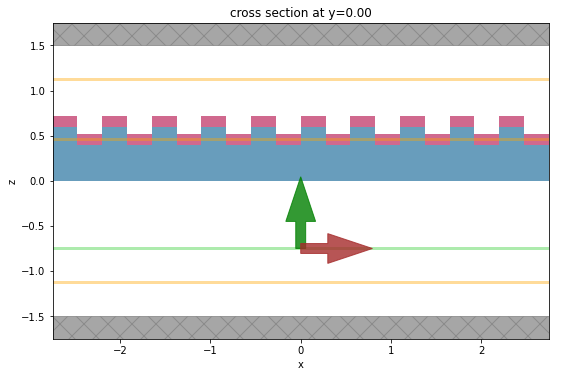

In [5]:
# create the simulation
sim = td.Simulation(
    center=[0, 0, 0],
    size=sim_size,
    grid_spec=grid_spec,
    structures=geometry,
    sources=[source],
    monitors=monitors,
    run_time=run_time,
    boundary_spec=boundary_spec,
    medium=water,
    shutoff=1e-6
)

# plot the simulation domain
f, ax = plt.subplots(tight_layout=True, figsize=(8, 6))
sim.plot(y=0, ax=ax)

In [6]:
# run simulation
import tidy3d.web as web
sim_data = web.run(sim, task_name='biosensor', path='data/biosensor.hdf5')

           INFO     Using Tidy3D credentials from stored file                      ]8;id=815401;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/auth.py\auth.py]8;;\:]8;id=98450;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/auth.py#74\74]8;;\

[19:21:29] INFO     Uploaded task 'biosensor' with task_id                      ]8;id=263063;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=260635;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#117\117]8;;\
                    '53eabd2a-e0c7-4eb3-8e36-66931301076f'.                                  

Output()

[19:21:32] INFO     status = queued                                             ]8;id=896594;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=957138;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#258\258]8;;\

Output()

[19:21:40] INFO     status = preprocess                                         ]8;id=49726;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=678048;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#270\270]8;;\

[19:21:41] INFO     Maximum flex unit cost: 2.05                                ]8;id=429466;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=454094;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#249\249]8;;\

[19:21:48] INFO     starting up solver                                          ]8;id=706344;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=483431;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#274\274]8;;\

[19:21:59] INFO     running solver                                              ]8;id=112480;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=891416;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#280\280]8;;\

Output()

Output()

[19:25:42] INFO     status = postprocess                                        ]8;id=824985;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=889988;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#303\303]8;;\

[19:25:55] INFO     status = success                                            ]8;id=429166;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=56038;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#303\303]8;;\

[19:25:56] INFO     downloading file "output/monitor_data.hdf5" to              ]8;id=565739;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=746308;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#575\575]8;;\
                    "data/biosensor.hdf5"                                                    

Output()

[19:26:03] INFO     loading SimulationData from data/biosensor.hdf5             ]8;id=407211;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=900112;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#397\397]8;;\

           WARNING  Simulation final field decay value of 5.93e-05 is greater   ]8;id=748818;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=918936;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#403\403]8;;\
                    than the simulation shutoff threshold of 1e-06. Consider                 
                    simulation again with large run_time duration for more                   
                    accurate results.                                                        

           INFO     Auto meshing using wavelength 0.8357 defined from        ]8;id=217309;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/components/grid/grid_spec.py\grid_spec.py]8;;\:]8;id=265195;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/components/grid/grid_spec.py#473\473]8;;\
                    sources.                                                                 

<AxesSubplot:title={'center':'cross section at z=0.00'}, xlabel='x', ylabel='y'>

<Figure size 648x288 with 2 Axes>

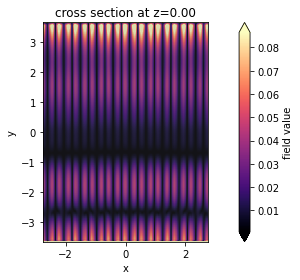

In [7]:
# plot fields on the monitor
fig, ax = plt.subplots(tight_layout=True, figsize=(9, 4))
sim_data.plot_field(field_monitor_name='fields_xy', field_name='Ey', val='abs', f=freq0, ax=ax)

<Figure size 540x360 with 1 Axes>

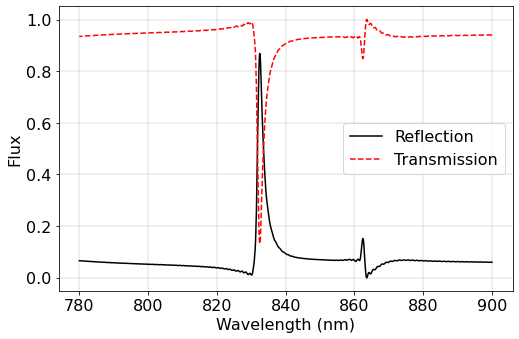

In [8]:
plt.rcParams.update({'font.size': 16})

transmission = sim_data["flux_tran"].flux
reflection = 1 - transmission

fig, ax = plt.subplots(figsize=(7.5, 5))
ax.plot(td.C_0 / freqs * 1e3, reflection, '-k', label="Reflection")
ax.plot(td.C_0 / freqs * 1e3, transmission, '--r', label="Transmission")
ax.set(xlabel = "Wavelength (nm)",
       ylabel = "Flux",
       yscale = 'linear',
       xscale = 'linear',
       # xlim = [500, 550]
      )
ax.legend()
ax.grid(visible = True, which = 'both', axis = 'both', linewidth = 0.4)
plt.tight_layout()
